In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install required libs
!pip install -U segmentation-models-pytorch albumentations --user 

Requirement already up-to-date: segmentation-models-pytorch in /root/.local/lib/python3.7/site-packages (0.2.0)
Requirement already up-to-date: albumentations in /root/.local/lib/python3.7/site-packages (1.0.2)


In [3]:
!pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html --user

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [5]:
#!pip uninstall -y segmentation-models-pytorch

In [ ]:
>>> import torch
>>> torch.cuda.is_available()

In [6]:
import tensorflow as tf
tf.version.VERSION

'2.5.0'

## Loading data

For this example we will use Monuseg dataset. It is a set of:
 - **train** images 
 - **validation** images 
 - **test** images 

Your dataset must be organized as the follwing path direction structure to run the model smoothly
 

In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [8]:

x_train_dir = os.path.join('/content/drive/MyDrive/kmms_test_exel/validation-processed-original-monuseg/train_folder/img')
y_train_dir = os.path.join('/content/drive/MyDrive/kmms_test_exel/validation-processed-original-monuseg/train_folder/labelcol')

x_valid_dir = os.path.join('/content/drive/MyDrive/kmms_test_exel/validation-processed-original-monuseg/validation_folder/img')
y_valid_dir = os.path.join('/content/drive/MyDrive/kmms_test_exel/validation-processed-original-monuseg/validation_folder/labelcol')


In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [11]:
from skimage.io import imread

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    '''
    def __getitem__(self, idx: int) -> Dict[str, Any]:
        idx = idx % len(self.samples)

        image_path, mask_path = self.samples[idx]

        image = load_rgb(image_path, lib="cv2")
        mask = load_grayscale(mask_path)

        # apply augmentations
        sample = self.transform(image=image, mask=mask)
        image, mask = sample["image"], sample["mask"]

        mask = (mask > 0).astype(np.uint8)

        mask = torch.from_numpy(mask)
    '''        
    
    #masks = np.zeros((24, 256, 256, 1), dtype=np.bool)
    
    def __getitem__(self, i):
        
        #dim = (480, 320)
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = np.zeros((256, 256), dtype=np.bool)
        mask_read = imread(self.masks_fps[i])
        mask = mask_read.astype(bool)
        mask = np.expand_dims(mask, axis=-1).astype(int)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

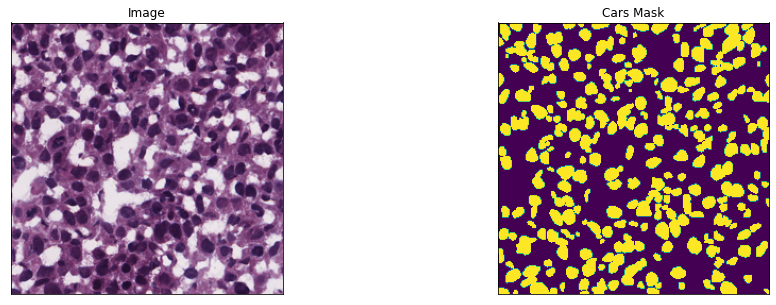

In [12]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[7] # get some sample

visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [15]:
print (mask.shape)

(256, 256, 1)


### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [13]:
import albumentations as albu

In [14]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        albu.RandomCrop(height=256, width=256, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(256, 256)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/root/.local/lib/python3.7/site-package

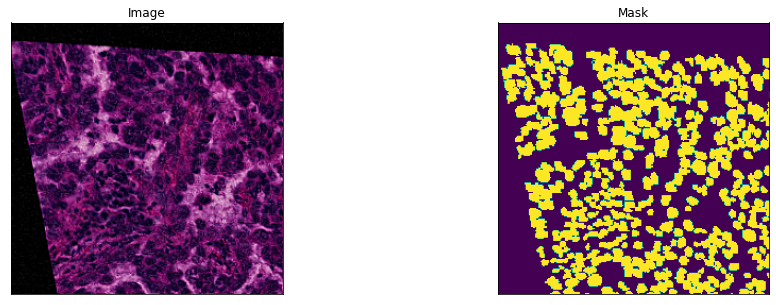

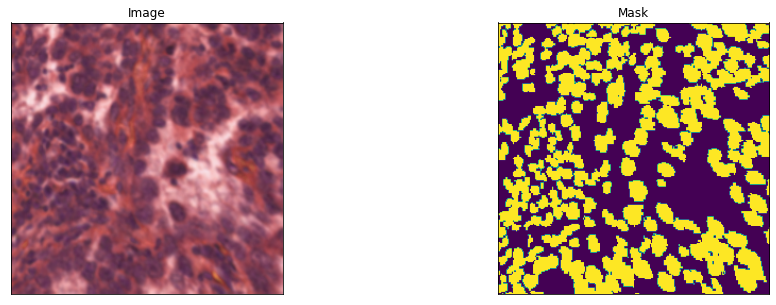

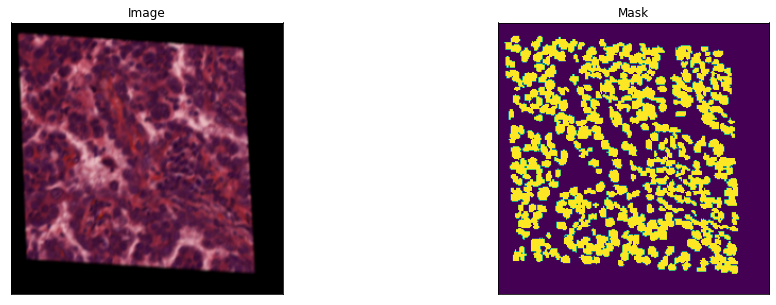

In [15]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car'],
)

image, mask = augmented_dataset[9]

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[5]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [16]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [17]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [19]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.7),
    smp.utils.metrics.Fscore(threshold=0.7),
    smp.utils.metrics.Accuracy(threshold=0.7),
    smp.utils.metrics.Recall(threshold=0.7),
    smp.utils.metrics.Precision(threshold=0.7),
]


optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [20]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [21]:
# train model for 280 epochs

max_score = 0

for i in range(0, 280):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './threshold_0.7_epoch_280_efficientnetb5_unet++_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s, dice_loss - 0.5602, iou_score - 0.09868, fscore - 0.1788, accuracy - 0.5754, recall - 0.1084, precision - 0.5124]
Model saved!

Epoch: 1
valid: 100%|██████████| 5/5 [00:00<00:00, 22.58it/s, dice_loss - 0.5123, iou_score - 0.168, fscore - 0.2843, accuracy - 0.5965, recall - 0.1913, precision - 0.554]
Model saved!

Epoch: 2
valid: 100%|██████████| 5/5 [00:00<00:00, 21.53it/s, dice_loss - 0.4763, iou_score - 0.2794, fscore - 0.4274, accuracy - 0.6406, recall - 0.3354, precision - 0.6056]
Model saved!

Epoch: 3
valid: 100%|██████████| 5/5 [00:00<00:00, 21.54it/s, dice_loss - 0.4431, iou_score - 0.3911, fscore - 0.5496, accuracy - 0.6744, recall - 0.5192, precision - 0.6096]
Model saved!

Epoch: 4
valid: 100%|██████████| 5/5 [00:00<00:00, 22.94it/s, dice_loss - 0.4267, iou_score - 0.4381, fscore - 0.5975, accuracy - 0.6862, recall - 0.609, precision - 0.6073]
Model saved!

Epoch: 5
valid: 100%|██████████| 5/5 [00:00<00:00, 23.35

## Test with MonuSeg

In [ ]:
# load best saved checkpoint
best_model = torch.load('./threshold_0.5_epoch_2000_efficientnetb3_unet++_model')

In [ ]:
x_test_dir = os.path.join('validation-processed-original-monuseg/monuseg_test_folder/img')
y_test_dir = os.path.join('validation-processed-original-monuseg/monuseg_test_folder/labelcol')

TNBC_x_test_dir = os.path.join('validation-processed-original-monuseg/TNBC_test_folder/img')
TNBC_y_test_dir = os.path.join('validation-processed-original-monuseg/TNBC_test_folder/labelcol')


In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

## Test with TNBC

In [ ]:
# create test dataset
TNBC_test_dataset = Dataset(
    TNBC_x_test_dir, 
    TNBC_y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

TNBC_test_dataloader = DataLoader(TNBC_test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(TNBC_test_dataloader)

In [ ]:
# test dataset without transformations for image visualization
TNBC_test_dataset_vis = Dataset(
    TNBC_x_test_dir, TNBC_y_test_dir, 
    classes=CLASSES,
)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = TNBC_test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = TNBC_test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )